In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('drive/MyDrive/Colab Notebooks/Chang')

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
class Generator(nn.Module):
  def __init__(self, hidden = 64):
    super().__init__()
    self.block = nn.Sequential(
        # 1st layer
        nn.ConvTranspose2d(100, hidden*8, 4, 1, 0, bias=False),
        nn.InstanceNorm2d(hidden*8),
        nn.LeakyReLU(0.2, inplace=True),
        # 2nd layer
        nn.ConvTranspose2d(hidden*8, hidden * 4, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(hidden * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # 3rd layer
        nn.ConvTranspose2d(hidden * 4, hidden * 2, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(hidden * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # 4th layer
        nn.ConvTranspose2d(hidden * 2, hidden, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(hidden * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # output layer
        nn.ConvTranspose2d(hidden, 1, 1, 1, 2, bias=False),
        nn.Tanh()
    )
  def forward(self, x):
    return self.block(x)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
from torchsummary import summary
model = Generator().to(device)
summary(model, input_size=(100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
    InstanceNorm2d-2            [-1, 512, 4, 4]               0
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
    InstanceNorm2d-5            [-1, 256, 8, 8]               0
         LeakyReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
    InstanceNorm2d-8          [-1, 128, 16, 16]               0
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
   InstanceNorm2d-11           [-1, 64, 32, 32]               0
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]              64
             Tanh-14            [-1, 1,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


In [8]:
class Discriminator(nn.Module):
  def __init__(self, hidden=64):
    super().__init__()
    self.block = nn.Sequential(
            nn.Conv2d(1, hidden, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden, hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 2, hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
  def forward(self, x):
    return self.block(x).view(-1, 1).squeeze(1)

In [9]:
model = Discriminator().to(device)
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,024
         LeakyReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,072
       BatchNorm2d-4            [-1, 128, 7, 7]             256
         LeakyReLU-5            [-1, 128, 7, 7]               0
            Conv2d-6            [-1, 256, 3, 3]         524,288
       BatchNorm2d-7            [-1, 256, 3, 3]             512
         LeakyReLU-8            [-1, 256, 3, 3]               0
            Conv2d-9              [-1, 1, 1, 1]           4,096
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 661,248
Trainable params: 661,248
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 2.52
Estimated T

In [13]:
train_dataset = datasets.MNIST(root="./data/", train=True, download=True, transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

In [11]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (block): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=Tru

In [14]:
criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 50
viz_noise = torch.randn(64, 100, 1, 1, device=device)

In [15]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(5):
    for i, data in enumerate(train_loader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(0.)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(1.)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, 5, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == 5-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/938]	Loss_D: 1.3855	Loss_G: 1.1175	D(x): 0.5313	D(G(z)): 0.5002 / 0.3426
[0/5][50/938]	Loss_D: 0.2529	Loss_G: 3.1292	D(x): 0.9326	D(G(z)): 0.1628 / 0.0501
[0/5][100/938]	Loss_D: 0.6983	Loss_G: 0.4927	D(x): 0.5550	D(G(z)): 0.0516 / 0.6242
[0/5][150/938]	Loss_D: 0.4489	Loss_G: 1.8413	D(x): 0.7832	D(G(z)): 0.1676 / 0.1782
[0/5][200/938]	Loss_D: 0.3439	Loss_G: 2.7143	D(x): 0.8805	D(G(z)): 0.1870 / 0.0755
[0/5][250/938]	Loss_D: 0.2933	Loss_G: 1.9167	D(x): 0.8027	D(G(z)): 0.0610 / 0.1657
[0/5][300/938]	Loss_D: 0.3624	Loss_G: 2.6083	D(x): 0.9283	D(G(z)): 0.2415 / 0.0845
[0/5][350/938]	Loss_D: 0.2417	Loss_G: 1.6953	D(x): 0.8256	D(G(z)): 0.0305 / 0.2165
[0/5][400/938]	Loss_D: 0.1891	Loss_G: 3.0244	D(x): 0.9217	D(G(z)): 0.0951 / 0.0678
[0/5][450/938]	Loss_D: 0.3245	Loss_G: 2.2615	D(x): 0.8032	D(G(z)): 0.0835 / 0.1303
[0/5][500/938]	Loss_D: 0.4084	Loss_G: 2.2273	D(x): 0.8413	D(G(z)): 0.1986 / 0.1217
[0/5][550/938]	Loss_D: 0.4774	Loss_G: 1.1876	D(x): 0.6850	D(G(z)

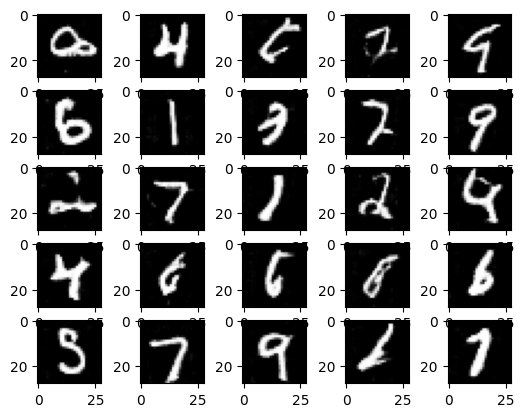

In [16]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = netG(fixed_noise)
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()
